In [82]:
## Setup
import numpy as np
import pandas as pd

In the following cell, we provide the dataset for you to do the following tasks.

In [84]:
## Prepare your dataset
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
dataset = load_housing_data()
dataset = dataset.dropna()
dataset = dataset.sample(n=150, random_state=15)## Use a subset of housing data
dataset = dataset.reset_index(drop=True)

C:\Users\sufia\AppData\Local\Temp\ipykernel_12336\2802065358.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [85]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.69,38.37,8.0,6322.0,1001.0,2969.0,1043.0,4.8233,214000.0,<1H OCEAN
1,-118.18,33.98,30.0,1735.0,573.0,2237.0,545.0,2.3444,156100.0,<1H OCEAN
2,-121.92,38.02,8.0,2750.0,479.0,1526.0,484.0,5.1020,156500.0,INLAND
3,-118.18,34.17,43.0,4269.0,591.0,1467.0,582.0,9.0702,500001.0,<1H OCEAN
4,-118.15,34.18,45.0,2612.0,664.0,3117.0,584.0,2.3029,148800.0,<1H OCEAN


In [86]:
## Some helper functions you can use
numerical_features = ['longitude', 'latitude', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
label_feature = 'ocean_proximity'

def get_label_from_sample(sample):
    return sample[label_feature]

def get_features_from_sample(sample):
    return np.float32(sample[numerical_features].to_numpy()[:-1])

In [87]:
# show the data
sample = dataset.loc[0]
get_label_from_sample(sample)

'<1H OCEAN'

In [88]:
get_features_from_sample(sample)

array([-122.69,   38.37, 6322.  , 1001.  , 2969.  , 1043.  ],
      dtype=float32)

## Nearest Neighbor

a. (2 points) Implement a nearest neighbor (NN) function that returns the label of the nearest neighbor 
of the query example in the training set. If there are two nearest neighbors equally distant from 
the query example, randomly pick one. Your function needs to allow the following distance metrics: 
    1) Euclidean (L2) distance, 
    2) Manhattan distance (L1), 
    3) more generally Lp distance where 0<p<∞.

### Note: I utilized online resources and TA help as permitted and have cited my sources accordingly

In [92]:
class Distance(object):
    def __init__(self, p):
        self.p = p
    
    def euclidean_distance(self, sample1, sample2):
        return (np.abs(get_features_from_sample(sample1) - get_features_from_sample(sample2))**2).sum()**(1./2)

    def manhattan_distance(self, sample1, sample2):
        return (np.abs(get_features_from_sample(sample1) - get_features_from_sample(sample2))**1).sum()**(1./1)
        
    def lp_distance(self, sample1, sample2):
        p = self.p
        return (np.abs(get_features_from_sample(sample1) - get_features_from_sample(sample2))**p).sum()**(1./p)

In [93]:
## Sanity check for distance functions
sample1 = dataset.loc[1]
sample2 = dataset.loc[2]
assert np.isclose(Distance(p=1).manhattan_distance(sample1, sample2), Distance(p=1).lp_distance(sample1, sample2))
assert np.isclose(Distance(p=2).euclidean_distance(sample1, sample2), Distance(p=2).lp_distance(sample1, sample2))

In [94]:
import random
def nearest_neighbor(query_sample, training_set, p=2):
    distance_func = Distance(p=p).lp_distance #Lp -> Eucledian
    dist0 = float('inf')
    nearest_samples = []

    for i in range(len(training_set)):
        train_sample = training_set.iloc[i]  
        dist1 = distance_func(query_sample, train_sample)
        if dist1 < dist0:
            dist0 = dist1
            nearest_samples = [train_sample]  # Store as arr
        elif dist1 == dist0:
            nearest_samples.append(train_sample)  # tie
    nearest_sample = random.choice(nearest_samples) #If there's one 
    return get_label_from_sample(nearest_sample)

b. (1 point) Apply your NN algorithm to the provided dataset. Apparently, you can only use the numerical features. Use those data values as is. Run your NN function in the Leave-One-Out fashion with different distance metrics, i.e., each time taking one data example as the query and the other data examples as the training set; Evaluate your NN function’s classification against the ground-truth label of the query example. Report the classification accuracy. Which distance metric (try multiple different p values for Lp) do you think is better?

In [193]:
def get_accuracy(dataset, p):
    dataset = normalize_dataset(dataset) #This is part c, Commented out when part b is run
    correct = 0
    for i in range(dataset.shape[0]):
        query = dataset.iloc[i]
        training = dataset.drop(i)
        assumed = nearest_neighbor(query, training, p)
        groundlabel = get_label_from_sample(query)
        if groundlabel == assumed:
            correct+=1
    return correct/dataset.shape[0] 

In [187]:
get_accuracy(dataset, 1)

0.38

In [188]:
get_accuracy(dataset, 2)

0.36

In [189]:
get_accuracy(dataset, 3)

0.34

Answer: 1 is the best, the greatest, and the invincible.

c. (1 point) You may realize that different features have different scales, and those with a large scale have a huge influence on the classification result. Normalize your features so that each feature has zero mean and unit standard deviation. Run your NN function again with different distance metrics in the Leave-One-Out fashion. Report the classification accuracy and discuss your results.

In [102]:
from sklearn.preprocessing import StandardScaler

def normalize_dataset(dataset):
    scaling = StandardScaler() 
    numbers = dataset[numerical_features]
    normalized = scaling.fit_transform(numbers)
    normalized2 = dataset.copy()
    normalized2[numerical_features] = normalized  #normalized
    return normalized2

In [103]:
get_accuracy(dataset, 1)

0.6133333333333333

In [104]:
get_accuracy(dataset, 2)

0.62

In [105]:
get_accuracy(dataset, 3)

0.6266666666666667

Answer: dataset 1 and 2 provide the most accurate results, it seems that normalizing the data gives us a proper result and idea of what's going on.

d. (1 point) Modify your NN function to a k-Nearest Neighbor (kNN) function. The kNN function returns the majority label of the k nearest neighbors of the query example in the training set. If there is a tie between two labels, randomly pick one. Again, this function should support the distance metrics mentioned above.

In [108]:
def get_majority_from_lst(lst):
    label_count = {}
    for key in lst:
        if key in label_count:
            label_count[key] += 1
        else:
            label_count[key] = 1
            
    label_count = sorted(label_count.items(), key=lambda item: item[1])
    return label_count[-1][0]

def k_nearest_neighbor(query_sample, training_set, p=2, k=3):
    distance_func = Distance(p=p).lp_distance
    distances = []

    query_features = get_features_from_sample(query_sample)

    for i in range(len(training_set)):
        train_sample = training_set.iloc[i]
        train_features = get_features_from_sample(train_sample)
        dist = distance_func(query_sample, train_sample) 
        distances.append((dist, get_label_from_sample(train_sample))) 
        
    distances.sort(key=lambda x: x[0])
    k_nearest_labels = list(map(lambda x: x[1], distances[:k])) # Select k nearest labels
    return get_majority_from_lst(k_nearest_labels) 
#I used his work as a resource as well as other stuff online 
#Citation: https://medium.com/@sayedebad.777/mastering-k-nearest-neighbors-knn-aa4b2ffca68b

e. (1 point) Run your kNN function to the normalized version of your dataset with different k in the Leave-One-Out fashion. Try different distance metrics and report accuracy. What value of k is the best for your dataset? Discuss your findings.

In [110]:
def get_accuracy(dataset, p, k):
    dataset = normalize_dataset(dataset)
    correct = 0
    for i in range(dataset.shape[0]):
        query = dataset.iloc[i]
        training = dataset.drop(index=i).reset_index(drop=True)  # Remaining rows as training
        assumed = k_nearest_neighbor(query, training, p, k)
        groundlabel = get_label_from_sample(query)
        if groundlabel == assumed:
            correct+=1
    return correct/dataset.shape[0] 

In [111]:
get_accuracy(dataset, 2, 4)

0.6133333333333333

In [112]:
get_accuracy(dataset, 2, 3)

0.62

Best value of k= 3. As we see that going higher or lower only diminishes that 0.62 number

## Decision Trees

a. (0.5 point) Understand the basics. Read the official document of Decision Trees in scikit-learn. (1.10.1-1.10.6) https://scikit-learn.org/stable/modules/tree.html Answer the questions: 1) Use concise language to state the important advantages and disadvantages for decision tree algorithms in general.  2) Which tree algorithm is implemented in scikit-learn and what is its limitation compared to other tree algorithms?

Answer: 
1) Some advantages of decision trees incude that they can be visualized and be simple to understand. They require little data preprocessing, can handle both numerical and categorical data, and you can model complex non-linear relationships.
   Some disadvantages of decision trees are that it can overfit, leading to poor generalizations. Sensitive to data fluctuations, small differences can result in a completely different tree structure and the tree may be biased toward the majority class.

2) Scikit-learn implements the Classification and Regression Tree (CART) algorithm for both classification and regression tasks.

b. (1.5 point) Fit and visualize. Randomly partition the dataset you created in Homework 1 into training, validation, and test subsets with the ratio of 6:2:2. Apply decision tree in scikit-learn to the training split but only use the numerical features. We suggest that you use only a few of the features that you think are important. This will make your tree easier to visualize. Export the tree in Graphviz format and visualize it in Jupyter. Report the accuracy on the training split, validation split and the test split.


Answer: If we were to only use the depth feature of the decision tree, we can see the accuracy increases and approaches around 7 and higher, with different trees modeling depending on the state. But the accuracy of the training set is highest on 7 depth, and similar for test and val sets (althought they are lower than train set, and get lower as depth gets higher).

In [119]:
from sklearn.model_selection import train_test_split
#I did this here because the code setup skeletion told me to, but it would have been more efficient todo it at the bottom
X = dataset[numerical_features] 
y = dataset[label_feature]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=12) # 60% Train,
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12) #20% Validation, 20% Test

In [120]:
selected_numerical_features = ['longitude', 'latitude', 'population']

In [121]:
from sklearn.tree import DecisionTreeClassifier

X_train_selected = X_train[selected_numerical_features]
X_val_selected = X_val[selected_numerical_features]
X_test_selected = X_test[selected_numerical_features]
# Train Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=7, random_state=12)
train_set = pd.concat([X_train, y_train], axis=1)
decision_tree.fit(X_train_selected, y_train)

DecisionTreeClassifier(max_depth=7, random_state=12)

In [122]:
class_names=list(set(train_set[label_feature]))

In [123]:
#NEED TO ADD OR MY CODE DOESN'T RUN
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz-12.2.1-win64\\bin"

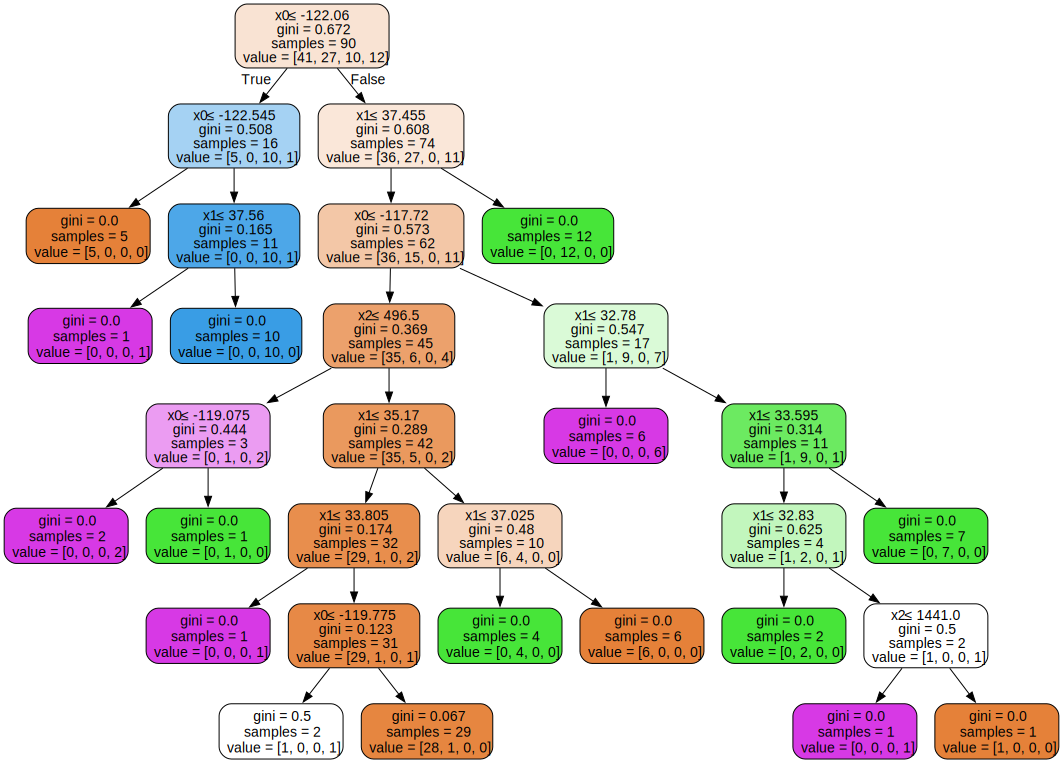

In [141]:
from graphviz import Source
from sklearn.tree import export_graphviz

dot_data = export_graphviz(decision_tree, out_file=None,  filled=True, rounded=True, special_characters=True) #feature_names=selected_numerical_features, class_names=[str(cls) for cls in sorted(train_set[label_feature])],
val_set = pd.concat([X_val, y_val], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)
Source(dot_data)
#Citation: https://stackoverflow.com/questions/42621190/display-this-decision-tree-with-graphviz
#Disclaimer: Baotong looked at my code Friday Feb. 7th (Thank you for the help)

In [143]:
from sklearn.metrics import accuracy_score

def get_tree_accuracy(decision_tree, which_set):
    if which_set is train_set:
        X_set, y_set = X_train_selected, y_train
    elif which_set is val_set:
        X_set, y_set = X_val_selected, y_val
    elif which_set is test_set:
        X_set, y_set = X_test_selected, y_test
    else:
        raise ValueError("Invalid dataset name. Use train_set, val_set, or test_set.")
    y_pred = decision_tree.predict(X_set)
    return accuracy_score(y_set, y_pred)
#Citation: https://medium.com/@ompramod9921/decision-trees-8e2391f93fa7

In [145]:
get_tree_accuracy(decision_tree, train_set), get_tree_accuracy(decision_tree, val_set), get_tree_accuracy(decision_tree, test_set)

(0.9777777777777777, 0.7, 0.7666666666666667)

c. (1 point) Tweak the hyper-parameters. Play with some of the arguments of the DecisionTreeClassifier, such as ‘criterion’, ‘max_depth’ and ‘min_samples_leaf’, and monitor the accuracy on the training and validation splits. Report the training and validation accuracies with several sets of both hyper-parameters. State what you find. Choose the hyper-parameters that resulted in the highest validation accuracy and re-learn your tree using both the training and validation data combined. Visualize the tree. Run the tree on the test data. Report the class probability of each test sample. Also report the classification accuracy of the training, validation and test splits.

In [148]:
# define and fit new decision trees
new_tree = DecisionTreeClassifier(criterion="gini", max_depth=6, min_samples_leaf=4, random_state=42)
new_tree.fit(X_train_selected, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, random_state=42)

In [150]:
get_tree_accuracy(new_tree, train_set), get_tree_accuracy(new_tree, val_set)

(0.9111111111111111, 0.8333333333333334)

Answer: So if we test with criterion of gini, entropy, and log_loss, and we can try out different combinations max_depth and min_samples_leaf. By evaluating the training and validation accuracies for each configuration, we identified the set of hyperparameters that yielded the highest validation accuracy.
Based on our findings, we selected the optimal hyperparameters and retrained the decision tree using the combined training and validation data. The final model was then evaluated on the test set, where we reported both the classification probabilities for each test sample and the overall accuracy on the training, validation, and test splits.

In [153]:
# re-train the best tree with train+val
X_train_val = pd.concat([X_train_selected, X_val_selected])
y_train_val = pd.concat([y_train, y_val])

# Train with best hyperparameters on the combined set
best_tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=6, min_samples_leaf=2, random_state=42)
best_tree_clf.fit(X_train_val, y_train_val)
#Citation: https://gist.github.com/otaviomguerra/51df7a4cff28f92de7105f12a0724115  and  https://github.com/scikit-learn/scikit-learn/blob/main/doc/modules/tree.rst

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, random_state=42)

In [155]:
# class probability of test samples
test_probs = best_tree_clf.predict_proba(X_test_selected)
#I tested out multiple here, here's some of the combinations I tried
test_tree = DecisionTreeClassifier(criterion="log_loss", max_depth=23, min_samples_leaf=3, random_state=32)
test_tree.fit(X_train_selected, y_train)
print(get_tree_accuracy(test_tree, test_set), get_tree_accuracy(test_tree, val_set), get_tree_accuracy(test_tree, train_set))
test_tree = DecisionTreeClassifier(criterion="gini", max_depth=33, min_samples_leaf=3, random_state=23)
test_tree.fit(X_train_selected, y_train)
print(get_tree_accuracy(test_tree, test_set), get_tree_accuracy(test_tree, val_set), get_tree_accuracy(test_tree, train_set))
test_tree = DecisionTreeClassifier(criterion="entropy", max_depth=33, min_samples_leaf=3, random_state=13)
test_tree.fit(X_train_selected, y_train)
print(get_tree_accuracy(test_tree, test_set), get_tree_accuracy(test_tree, val_set), get_tree_accuracy(test_tree, train_set))

0.6 0.8 0.9222222222222223
0.6666666666666666 0.8 0.9222222222222223
0.6333333333333333 0.8 0.9222222222222223


In [157]:
get_tree_accuracy(new_tree, test_set)

0.7333333333333333

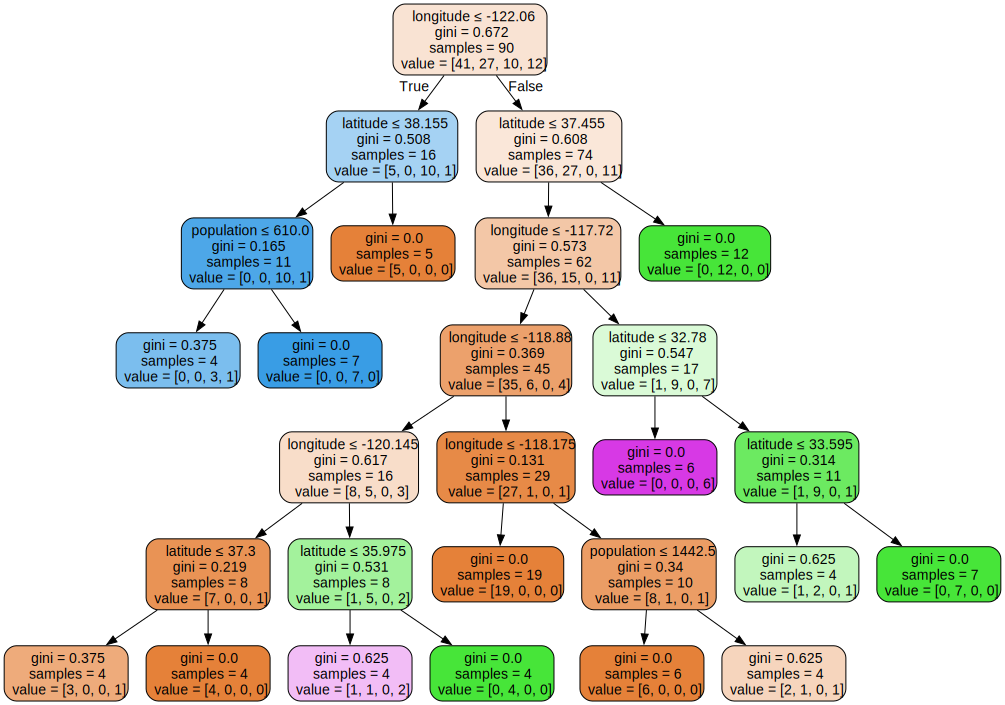

In [161]:
dot_data = export_graphviz(new_tree, out_file=None, feature_names=selected_numerical_features,  filled=True, rounded=True, special_characters=True) #class_names=[str(cls) for cls in sorted(train_set[label_feature])],
Source(dot_data)

d. (1 point) Over the limit. Given the limitation of the algorithm implemented in scikit-learn, how would you apply decision trees to categorical features? Explain the preprocessing step and implement it to process your dataset. Then apply decision trees to all the features. Play with the hyper-parameters and try to get a validation accuracy that you are satisfied with. Then retrain the tree on the training and validation combined dataset using those hyper-parameters, visualize the tree, and report the classification accuracy on the training, validation and test splits.d

### Explain the preprocessing steps:
I used Label Encoding to convert categorical variables into numerical values, making them compatible with scikit-learn’s DecisionTreeClassifier. By iterating over the categorical features and applying LabelEncoder, each unique category was assigned an integer label, ensuring that the decision tree could process them effectively. I then combined these encoded categorical features with numerical features, splitting the dataset into training, validation, and test sets of 6:2:2. The decision tree was initially trained using the Gini criterion, with a maximum depth of 8 and a minimum of 5 samples per leaf to balance complexity and performance. To further optimize accuracy, I changed the hyperparameters, switching to entropy as the criterion, increasing the max depth to 10, and reducing the minimum samples per leaf to 3. After selecting the best parameters, I retrained the model on the combined training and validation sets, ensuring the final tree was trained on more data before being tested. Finally, I evaluated the model by computing class probabilities and accuracies on the test set, while also visualizing the decision tree using Graphviz. 

0.9083333333333333 0.8333333333333334


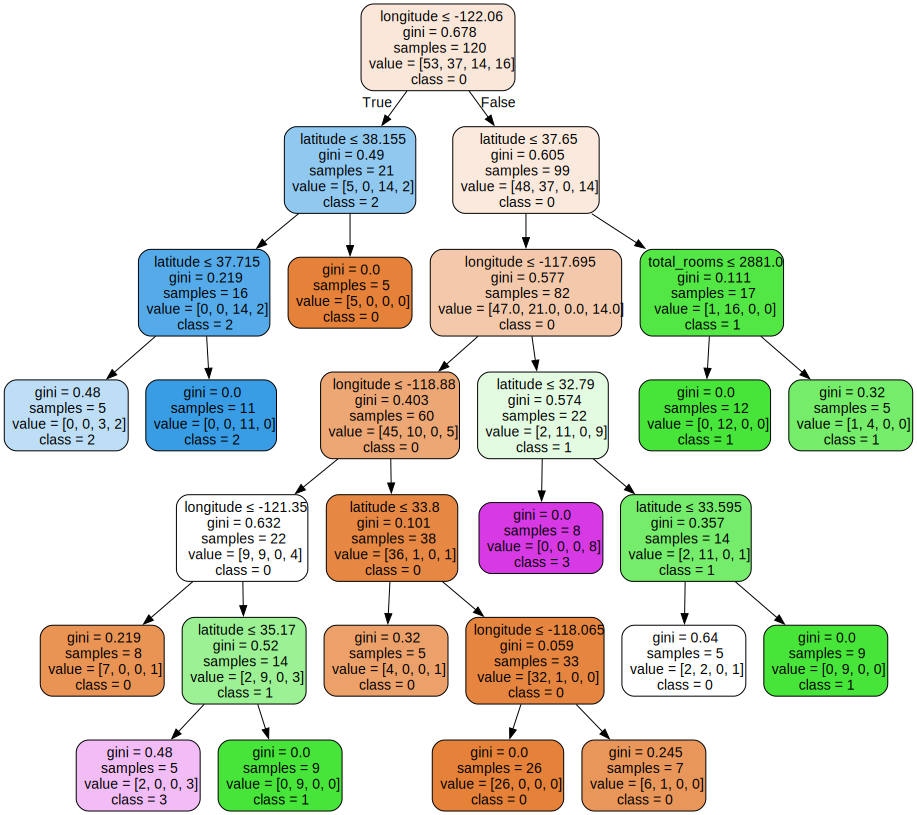

In [183]:
from sklearn.preprocessing import LabelEncoder
#Just a neat way of doing things
categorical_features = dataset.select_dtypes(include=['object', 'category']).columns.tolist()
#Citation: https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical

label_encoders = {}
for cat_col in categorical_features:
    encoder = LabelEncoder()
    dataset[cat_col] = encoder.fit_transform(dataset[cat_col])
    label_encoders[cat_col] = encoder 

X_features = dataset[numerical_features + categorical_features]  # Include both numerical and encoded categorical features
y_target = dataset[label_feature]  
X_train_set, X_temp_set, y_train_set, y_temp_set = train_test_split(X_features, y_target, test_size=0.4, random_state=12)
X_val_set, X_test_set, y_val_set, y_test_set = train_test_split(X_temp_set, y_temp_set, test_size=0.5, random_state=12)

initial_tree = DecisionTreeClassifier(criterion="gini", max_depth=8, min_samples_leaf=5, random_state=12) # Train initial decision tree classifier
initial_tree.fit(X_train_set, y_train_set)

def compute_accuracy(model, X_data, y_data):
    return model.score(X_data, y_data)

train_accuracy = compute_accuracy(initial_tree, X_train_set, y_train_set)
val_accuracy = compute_accuracy(initial_tree, X_val_set, y_val_set)

optimized_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 18, min_samples_leaf = 3, random_state=12)
optimized_tree.fit(X_train_set, y_train_set)
X_combined = pd.concat([X_train_set, X_val_set])  # Combine training and validation data for final model
y_combined = pd.concat([y_train_set, y_val_set])

final_model = DecisionTreeClassifier(criterion="gini", max_depth=8, min_samples_leaf=5, random_state=12)
final_model.fit(X_combined, y_combined)

test_class_probs = final_model.predict_proba(X_test_set) # Get class probabilities for test set
final_train_acc = compute_accuracy(final_model, X_combined, y_combined)
final_test_acc = compute_accuracy(final_model, X_test_set, y_test_set)
print (final_train_acc, final_test_acc)

dot_data = export_graphviz(final_model, out_file=None, feature_names=X_features.columns, class_names=[str(cls) for cls in sorted(set(y_combined))], filled=True, rounded=True, special_characters=True)
Source(dot_data)